# Explore UniProt keywords

url: https://www.uniprot.org/uniprotkb?facets=reviewed%3Atrue&query=%28taxonomy_id%3A9606%29
1. Select the following columns:
Entry	Entry Name	Protein Names	Gene Names	Organism	Keywords HGNC

2. Select Reviewed only (~20,500)

In [1]:
from collections import Counter

import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import os.path as osp
import json

Below, I downloaded the [UniProt table for human proteins](https://www.uniprot.org/uniprotkb?query=%28Human%29). I added on Keywords and HGNC as columns:

In [2]:
MAPPING_DIR = '../data/mappings/'

In [3]:
# Release 2022_05
uniprot = pd.read_csv(
    osp.join(MAPPING_DIR, 'uniprotkb_Human_AND_reviewed_true_2023_10_05.tsv.gz'),
    sep='\t',
    compression='gzip',
    usecols=[
        'Keywords',
        'Entry',
    ]
)

In [4]:
uniprot.head(10)

,Entry,Keywords
0,A0A024B7W1,3D-structure;4Fe-4S;Activation of host autopha...
1,A0A068B6Q6,3D-structure;Acetylcholine receptor inhibiting...
2,A0A076FFM5,2Fe-2S;Chloroplast;Cytoplasm;Iron;Iron-sulfur;...
3,A0A087X1C5,Cytoplasm;Glycoprotein;Heme;Iron;Membrane;Meta...
4,A0A0A1I6E7,Amidation;Antibiotic;Antimicrobial;Cleavage on...
5,A0A0A1I6N9,Amidation;Antibiotic;Antimicrobial;Cleavage on...
6,A0A0B4J2F0,Direct protein sequencing;Membrane;Mitochondri...
7,A0A0B4J2F2,ATP-binding;Kinase;Magnesium;Metal-binding;Nuc...
8,A0A0B4KGY6,Alternative splicing;Cytoplasm;mRNA processing...
9,A0A0B4U9L8,Calcium;Cell adhesion impairing toxin;Direct p...


Get our KG and all the protein nodes inside. We are getting the KG which includes the test set:

In [5]:
KG_DIR = '../data/kg'

In [6]:
kg = pd.read_csv(osp.join(KG_DIR, 'full_final_kg.tsv'), sep='\t')

Get the proteins:

In [7]:
target_sets = set(kg[kg['target'].str.startswith('ncbigene')]['target'].tolist())
source_sets = set(kg[kg['source'].str.startswith('ncbigene')]['source'].tolist())
proteins_in_kg = target_sets.union(source_sets)
len(proteins_in_kg)

4037

Next, let's get a mapping from UniProt to NCBI gene ID:

In [8]:
with open(osp.join(MAPPING_DIR, 'uniprot2ncbi.json')) as f:
    uniprot2ncbi = json.load(f)

Get the valid protein classes:

In [9]:
valid_keywords = pd.read_csv(
    osp.join(MAPPING_DIR, 'molecular_function.tsv'),
    sep='\t',
)

In [10]:
valid_keywords

,Keyword ID,Name,Category,Gene Ontologies
0,KW-0008,Acetylcholine receptor inhibiting toxin,Molecular function,GO:0030550:acetylcholine receptor inhibitor ac...
1,KW-0009,Actin-binding,Molecular function,GO:0003779:actin binding
2,KW-0010,Activator,Molecular function,NaN
3,KW-0012,Acyltransferase,Molecular function,GO:0016746:acyltransferase activity
4,KW-0021,Allosteric enzyme,Molecular function,"GO:0003824:catalytic activity, GO:0008152:meta..."
...,...,...,...,...
193,KW-1244,Viral short tail ejection system,Molecular function,GO:0099002:viral genome ejection through host ...
194,KW-1255,Viral exotoxin,Molecular function,NaN
195,KW-1265,Chloride channel impairing toxin,Molecular function,NaN
196,KW-1275,Proton-gated sodium channel impairing toxin,Molecular function,NaN


In [11]:
molecular_functions = valid_keywords.Name.unique()

Now, we'll make a dictionary mapping each of our KG proteins to their protein class (or keywords):

In [12]:
all_keywords = []

not_mapped = 0
no_keywords = 0

protein_to_keywords = {}

for prot_name, keywords in tqdm(uniprot.values):
    # Map from UniProt to NCBI
    if 'UniProt:' + str(prot_name) not in uniprot2ncbi:
        not_mapped += 1
        continue
    
    """Get keywords"""
    protein_keywords = set()
    
    for keyword in keywords.split(';'):
        
        if keyword not in molecular_functions:
            continue
        
        protein_keywords.add(keyword.strip())
        all_keywords.append(keyword.strip())
        
    if not protein_keywords:
        no_keywords += 1
        continue
        
    protein_to_keywords[uniprot2ncbi['UniProt:' + str(prot_name)]] = protein_keywords

100%|██████████| 51790/51790 [00:02<00:00, 24769.16it/s]


In [13]:
len(protein_to_keywords), no_keywords, not_mapped, len(set(all_keywords))

(11220, 8880, 31690, 130)

Which keywords are most common? 

In [14]:
valid_keywords = [
    k
    for k, c in Counter(all_keywords).items()
    if c > 50
]

In [15]:
len(valid_keywords)

61

Removing superclasses and keywords with a few proteins

In [16]:
protein_to_keywords = {
    protein: {
        keyword
        for keyword in keywords
        if keyword in valid_keywords and keyword not in [
            'Transducer',
            'Serine/threonine-protein kinase',
            'Activator',
        ]
    }
    for protein, keywords in protein_to_keywords.items()
}

Map the proteins in our KG to Uniprot keywords:

In [17]:
nodes2keywords = {key: val for key, val in protein_to_keywords.items() if key in proteins_in_kg and len(val) > 0}

Those which map to classes:

In [18]:
len(nodes2keywords)

2769

Those which don't:

In [19]:
len(proteins_in_kg) - len(nodes2keywords)

1268

In [20]:
2769 / (1268+2769)

0.6859053752786722

Get some further stats:

In [21]:
keywords_in_nodes = list()
number_of_keywords = dict()
for key, val in nodes2keywords.items():
    keywords_in_nodes.extend(list(val))
    number_of_keywords[key] = len(val)

Let's see the most popular classes:

In [22]:
most_popular = Counter(keywords_in_nodes)
most_popular.most_common()

[('Receptor', 520),
 ('DNA-binding', 511),
 ('Transferase', 448),
 ('Hydrolase', 392),
 ('Developmental protein', 285),
 ('Kinase', 269),
 ('G-protein coupled receptor', 246),
 ('RNA-binding', 203),
 ('Repressor', 198),
 ('Oxidoreductase', 147),
 ('Ion channel', 122),
 ('Cytokine', 114),
 ('Chromatin regulator', 102),
 ('Protease', 96),
 ('Growth factor', 85),
 ('Ribonucleoprotein', 83),
 ('Tyrosine-protein kinase', 64),
 ('Chaperone', 57),
 ('Hormone', 56),
 ('Voltage-gated channel', 55),
 ('Actin-binding', 52),
 ('Calmodulin-binding', 51),
 ('Heparin-binding', 51),
 ('Helicase', 51),
 ('GTPase activation', 51),
 ('Protein phosphatase', 50),
 ('Lyase', 41),
 ('Ribosomal protein', 38),
 ('Ligand-gated ion channel', 37),
 ('Motor protein', 34),
 ('Serine protease', 33),
 ('Nuclease', 32),
 ('Guanine-nucleotide releasing factor', 32),
 ('Calcium channel', 31),
 ('Host cell receptor for virus entry', 31),
 ('Metalloprotease', 30),
 ('Protease inhibitor', 30),
 ('Methyltransferase', 29),
 

How many classes per protein?

Text(-2.700000000000003, 0.5, 'Number of nodes')

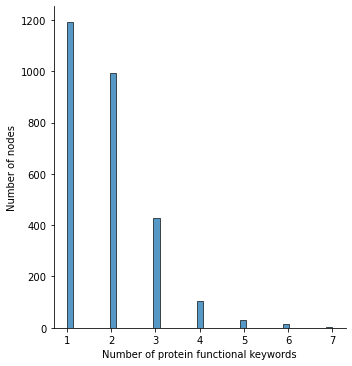

In [23]:
sns.displot(list(number_of_keywords.values()))
# add x axis label
plt.xlabel("Number of protein functional keywords")
# add y axis label
plt.ylabel("Number of nodes")

From those above, we want to reduce the number of keywords. Let's see how many keywords are amongst those with just 1 keyword:

In [24]:
# get all the protein IDs
single_keyword = {key for key, val in number_of_keywords.items() if val == 1}

In [25]:
# and then the corresponding keywords to those proteins
kws = set()
for key, val in nodes2keywords.items():
    if key in single_keyword:
        kws.update(val)

In [26]:
# now subet nodes2keywords to include only those proteins with a single keyword
nodes2keywords = {key: val.intersection(kws) for key, val in nodes2keywords.items() if len(val.intersection(kws)) > 0}

In [27]:
len(nodes2keywords)

2766

How much of the proteins in the KG does that cover?

In [28]:
len(nodes2keywords) / len(proteins_in_kg)

0.6851622491949467

In [29]:
len(kws)

27

So if we narrow it down to these 27 classes, we still include all the proteins we had before.

In [30]:
# get most_popular for only terms for kws
keyword_freqs = {key: val for key, val in most_popular.items() if key in kws}
keyword_freqs

{'Repressor': 198,
 'DNA-binding': 511,
 'Hydrolase': 392,
 'Developmental protein': 285,
 'Motor protein': 34,
 'Transferase': 448,
 'Calmodulin-binding': 51,
 'Actin-binding': 52,
 'Chromatin regulator': 102,
 'Ion channel': 122,
 'Receptor': 520,
 'Cytokine': 114,
 'Growth factor': 85,
 'Oxidoreductase': 147,
 'Heparin-binding': 51,
 'Ligase': 14,
 'Chaperone': 57,
 'Isomerase': 28,
 'Ribonucleoprotein': 83,
 'GTPase activation': 51,
 'Muscle protein': 13,
 'RNA-binding': 203,
 'Translocase': 23,
 'Protease inhibitor': 30,
 'Lyase': 41,
 'Guanine-nucleotide releasing factor': 32,
 'Hormone': 56}

Okay, let's get a dictionary mapping proteins in the KG to their class. If they don't map to anything, map them to a generic protein class ('Gene', to keep it consistent with the KG).

In [31]:
node2class = dict()

for node in proteins_in_kg:
    if node in nodes2keywords:
        node2class[node] = list(nodes2keywords[node])
    else:
        node2class[node] = ['Gene']

In [32]:
node2class

{'ncbigene:3767': ['Ion channel'],
 'ncbigene:57413': ['Gene'],
 'ncbigene:4881': ['Receptor', 'Lyase'],
 'ncbigene:146057': ['Transferase'],
 'ncbigene:8387': ['Receptor'],
 'ncbigene:7936': ['Repressor', 'RNA-binding'],
 'ncbigene:5445': ['Hydrolase'],
 'ncbigene:6372': ['Cytokine', 'Heparin-binding'],
 'ncbigene:132112': ['Gene'],
 'ncbigene:839': ['Hydrolase'],
 'ncbigene:2742': ['Ion channel', 'Receptor'],
 'ncbigene:3009': ['DNA-binding'],
 'ncbigene:4055': ['Receptor'],
 'ncbigene:9883': ['Gene'],
 'ncbigene:344901': ['Hormone', 'Developmental protein'],
 'ncbigene:23014': ['Gene'],
 'ncbigene:5106': ['Lyase'],
 'ncbigene:140679': ['Gene'],
 'ncbigene:1852': ['Hydrolase'],
 'ncbigene:51411': ['Gene'],
 'ncbigene:5295': ['Gene'],
 'ncbigene:4855': ['Receptor', 'Developmental protein'],
 'ncbigene:1482': ['DNA-binding', 'Developmental protein'],
 'ncbigene:55746': ['Gene'],
 'ncbigene:7074': ['Guanine-nucleotide releasing factor'],
 'ncbigene:796': ['Gene'],
 'ncbigene:351': ['Hep

In [33]:
len(node2class) == len(proteins_in_kg)

True

In [34]:
# write dictionary to json file in MAPPING_DIR
with open(osp.join(MAPPING_DIR, 'node2class.json'), 'w') as f:
    json.dump(node2class, f, indent=4)